In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [179]:
train_data = pd.read_csv('problem_2_train.csv',  parse_dates=['memcreateddate','mobilepurchasedate','claimintdate','pickupStartdate'])
train_data.head()

,srno,mobmake,hubid,hubpincode,pickuppartnerid,deliverypartnerid,insuranceCompanyId,custpincodecategory,claimtype,custpincode,memcreateddate,mobilepurchasedate,claimintdate,servicecntrid,pickupStartdate,tat_in_days
0,2851218,AN,7,500004,233,233,131,A,ADLD,500001,2017-04-27,2016-12-02,2018-02-08,4403,2018-02-13,5
1,2838330,AJ,10,226010,233,233,131,A,ADLD,226022,2017-03-06,2017-03-05,2018-02-04,4444,2018-02-08,12
2,2835781,AJ,2,110018,233,233,228,A,ADLD,110018,2018-02-01,2018-01-27,2018-02-03,4388,2018-02-12,9
3,2838589,AM,2,110018,233,233,228,B,ADLD,124001,2018-01-17,2018-01-31,2018-02-04,4092,2018-02-14,9
4,2855214,AN,21,110015,233,233,131,A,ADLD,201301,2018-01-23,2018-01-20,2018-02-09,4580,2018-02-14,8


In [180]:
train_data.shape

(6250, 16)

<h2>Catagorical data</h2>

In [181]:
claims = {'ADLD': 0, 'EW': 1}
train_data['claimtype'] = train_data['claimtype'].map(claims)

In [182]:
x = train_data.mobmake.unique()
mobiles = {}
i = 0
for mob in x:
    mobiles[mob] = i
    i+=1
train_data['mobmake'] = train_data['mobmake'].map(mobiles)

In [183]:
custpin = {'A': 0, 'B': 1, 'C': 2, 'D': 3, '0': 4}
train_data['custpincodecategory'] = train_data['custpincodecategory'].map(custpin)

<h2>Setting date values with dates</h2>

In [184]:
train_data['memcreateddate'] = train_data['memcreateddate'].dt.day
train_data['mobilepurchasedate'] = train_data['mobilepurchasedate'].dt.day
train_data['claimintdate'] = train_data['claimintdate'].dt.day
train_data['pickupStartdate'] = train_data['pickupStartdate'].dt.day

In [185]:
train_data.head()

,srno,mobmake,hubid,hubpincode,pickuppartnerid,deliverypartnerid,insuranceCompanyId,custpincodecategory,claimtype,custpincode,memcreateddate,mobilepurchasedate,claimintdate,servicecntrid,pickupStartdate,tat_in_days
0,2851218,0,7,500004,233,233,131,0,0,500001,27,2,8,4403,13,5
1,2838330,1,10,226010,233,233,131,0,0,226022,6,5,4,4444,8,12
2,2835781,1,2,110018,233,233,228,0,0,110018,1,27,3,4388,12,9
3,2838589,2,2,110018,233,233,228,1,0,124001,17,31,4,4092,14,9
4,2855214,0,21,110015,233,233,131,0,0,201301,23,20,9,4580,14,8


new_col = abs(train_data['pickupStartdate'] - train_data['claimintdate'])
train_data.insert(15,'TAT',new_col,True)

<h2>Feature Selection using SelectKBest library</h2>

In [186]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = train_data.iloc[:,0:16]
y = train_data.iloc[:,-1]   

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))  

                  Specs         Score
9           custpincode  1.478647e+07
3            hubpincode  1.383064e+07
0                  srno  5.505007e+05
15          tat_in_days  1.264538e+04
1               mobmake  4.268939e+03
13        servicecntrid  1.949402e+03
8             claimtype  1.604200e+03
7   custpincodecategory  1.085144e+03
2                 hubid  9.176406e+02
4       pickuppartnerid  7.976258e+02


<h2>Feature Selection using Heat map</h2>

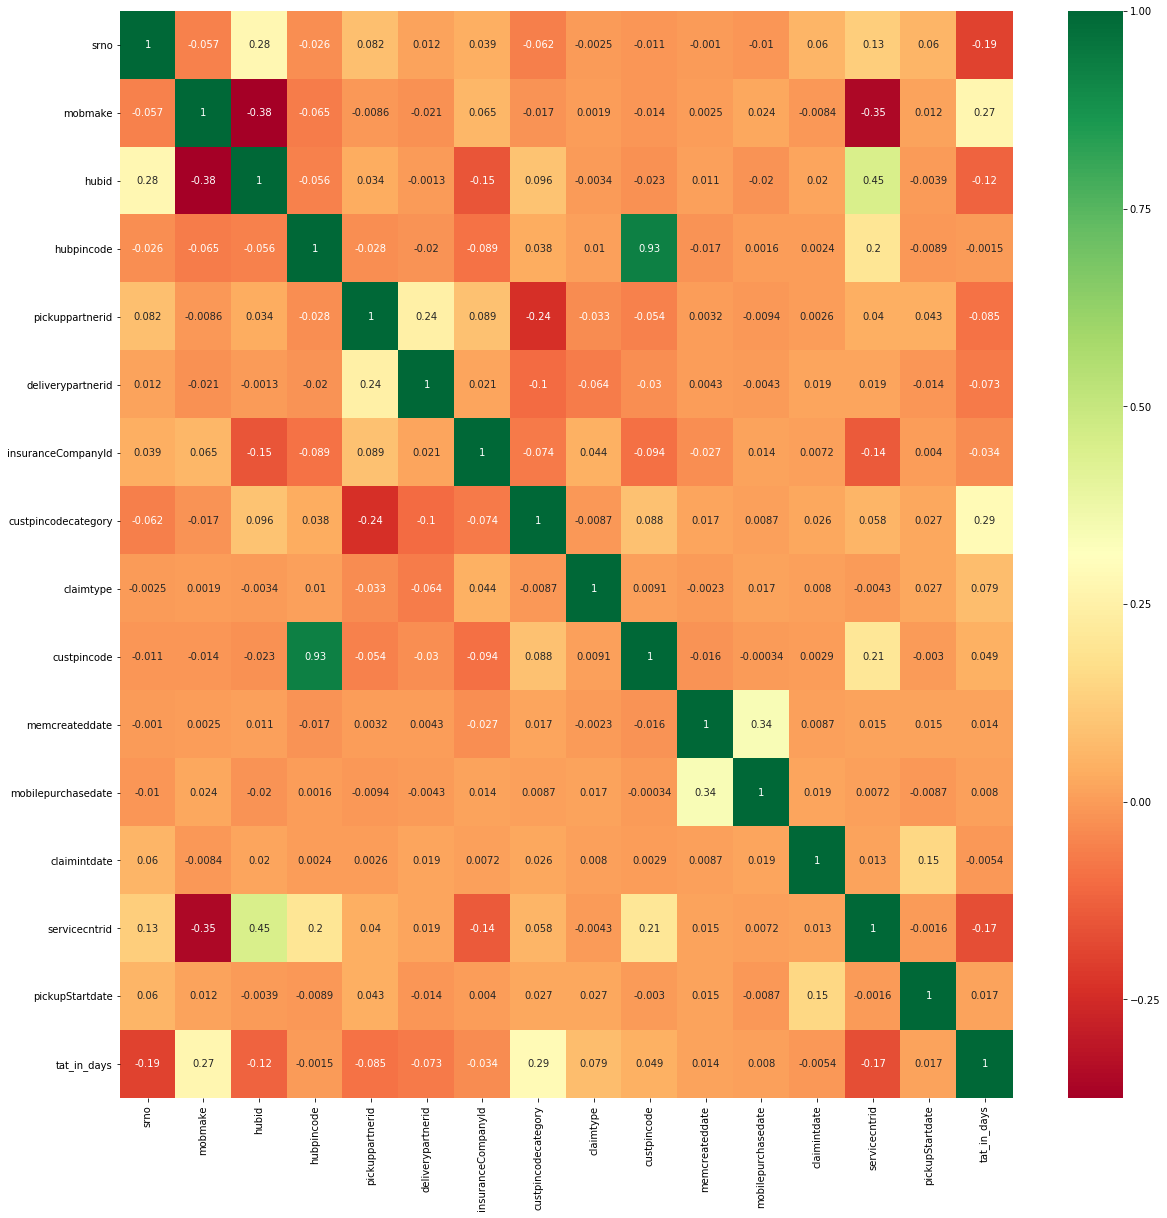

In [187]:
corrmat = train_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [188]:
train_data.columns

Index(['srno', 'mobmake', 'hubid', 'hubpincode', 'pickuppartnerid',
       'deliverypartnerid', 'insuranceCompanyId', 'custpincodecategory',
       'claimtype', 'custpincode', 'memcreateddate', 'mobilepurchasedate',
       'claimintdate', 'servicecntrid', 'pickupStartdate', 'tat_in_days'],
      dtype='object')

<h2>Training the train_data using Linear Regression</h2>

In [189]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [190]:
features = ['custpincode','hubpincode','srno','mobmake','servicecntrid','claimtype','custpincodecategory','hubid','pickupStartdate']

X = train_data[features]
y = train_data.tat_in_days

for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    m=mean_squared_error(y_test, y_pred)
    print('RMSE: ',i, ' ' ,np.sqrt(m))

In [191]:
X = train_data[features]
y = train_data.tat_in_days

#RMSE is best on random_state value=7...so taking it as 7
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [192]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

In [193]:
m=mean_squared_error(y_test, y_pred)
print('RMSE: ', np.sqrt(m))

RMSE:  4.40925389565299


In [194]:
print('Score: ', linreg.score(X_test, y_test))

Score:  0.2237747838529277


<h3>Graphical representation of Actual vs Predicted data</h3>

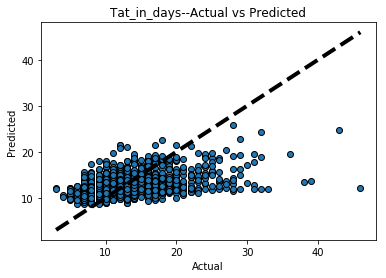

In [195]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Tat_in_days--Actual vs Predicted")
plt.show()

<h2>Training the train_data using Polynomial Regression</h2>

In [196]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [197]:
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X)
X_test_ = poly.fit_transform(X_test)

In [198]:
lg = LinearRegression()
lg.fit(X_, y)
#lg.coef_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [199]:
y_prediction = lg.predict(X_test_)

In [200]:
ms = mean_squared_error(y_test, y_prediction)
print('RMSE: ', np.sqrt(ms))

RMSE:  4.2432374311076035


In [201]:
lg.score(X_test_, y_test)

0.281126955343717

<h3>Graphical representation of Actual vs Predicted data</h3>

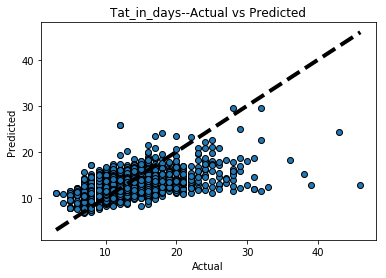

In [202]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_prediction, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Tat_in_days--Actual vs Predicted")
plt.show()

<h2>Predicting tat_in_days for Test data</h2>

In [203]:
test_data = pd.read_csv('problem_2_test.csv', parse_dates=['memcreateddate','mobilepurchasedate','claimintdate','pickupStartdate'])

In [204]:
test_data['memcreateddate'] = test_data['memcreateddate'].dt.day
test_data['mobilepurchasedate'] = test_data['mobilepurchasedate'].dt.day
test_data['claimintdate'] = test_data['claimintdate'].dt.day
test_data['pickupStartdate'] = test_data['pickupStartdate'].dt.day

In [205]:
claims = {'ADLD': 0, 'EW': 1}
test_data['claimtype'] = test_data['claimtype'].map(claims)

In [206]:
xx = test_data.mobmake.unique()
mobiless = {}
i = 0
for mob in xx:
    mobiless[mob] = i
    i+=1


In [207]:
test_data['mobmake'] = test_data['mobmake'].map(mobiless)

In [208]:
custpin = {'A': 0, 'B': 1, 'C': 2, 'D': 3, '0': 4}
test_data['custpincodecategory'] = test_data['custpincodecategory'].map(custpin)

In [209]:
newX = test_data[features]

<h3>Prediction on Polynomial regression model</h3>

In [210]:
newX_test_ = poly.fit_transform(newX)
ms = lg.predict(newX_test_)
test_data['tat_in_days'] = ms
ms

array([10.20954885, 11.81695887, 15.18413128, ..., 11.64917166,
       11.9814613 , 12.79209393])

In [211]:
test_data['tat_in_days'] = (test_data['tat_in_days']).astype(int)

In [212]:
test_data.head()

,srno,mobmake,hubid,hubpincode,pickuppartnerid,deliverypartnerid,insuranceCompanyId,custpincodecategory,claimtype,custpincode,memcreateddate,mobilepurchasedate,claimintdate,servicecntrid,pickupStartdate,tat_in_days
0,2829088,0,3,560011,233,233,131,0,0,560093,30,27,1,4467,6,10
1,2829866,1,2,110018,233,233,228,0,0,110034,17,25,1,4388,8,11
2,2894489,1,3,560011,233,233,228,2,0,590014,12,11,21,4460,28,15
3,2876708,1,2,110018,233,233,228,1,0,250110,7,21,16,4388,26,15
4,2890283,0,22,400104,233,233,131,2,0,496001,10,22,20,4581,23,16


In [213]:
test_data.to_csv('problem2_new_test.csv')